In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 828)
(1755717, 3)
validation
(308504, 828)
(308504, 3)
test
(223783, 828)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1538307 (5.87 MB)


Trainable params: 1538307 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:44 - loss: 1.2561 - STD: 0.2181 - MAE: 0.4370

  5/176 [..............................] - ETA: 2s - loss: 1.1446 - STD: 0.1421 - MAE: 0.4326  

  8/176 [>.............................] - ETA: 2s - loss: 1.1176 - STD: 0.1161 - MAE: 0.4329

 12/176 [=>............................] - ETA: 2s - loss: 1.1043 - STD: 0.1136 - MAE: 0.4314

 16/176 [=>............................] - ETA: 2s - loss: 1.0876 - STD: 0.1054 - MAE: 0.4295

 20/176 [==>...........................] - ETA: 2s - loss: 1.0666 - STD: 0.1023 - MAE: 0.4253

 24/176 [===>..........................] - ETA: 2s - loss: 1.0337 - STD: 0.1070 - MAE: 0.4167

 28/176 [===>..........................] - ETA: 2s - loss: 0.9901 - STD: 0.1218 - MAE: 0.4026

 32/176 [====>.........................] - ETA: 2s - loss: 0.9472 - STD: 0.1405 - MAE: 0.3870

 36/176 [=====>........................] - ETA: 2s - loss: 0.9102 - STD: 0.1593 - MAE: 0.3717

 40/176 [=====>........................] - ETA: 2s - loss: 0.8785 - STD: 0.1754 - MAE: 0.3584

 44/176 [======>.......................] - ETA: 2s - loss: 0.8500 - STD: 0.1881 - MAE: 0.3473

 48/176 [=======>......................] - ETA: 1s - loss: 0.8252 - STD: 0.1988 - MAE: 0.3377

 52/176 [=======>......................] - ETA: 1s - loss: 0.8023 - STD: 0.2084 - MAE: 0.3288

 56/176 [========>.....................] - ETA: 1s - loss: 0.7809 - STD: 0.2176 - MAE: 0.3201

 60/176 [=========>....................] - ETA: 1s - loss: 0.7610 - STD: 0.2262 - MAE: 0.3119

 64/176 [=========>....................] - ETA: 1s - loss: 0.7421 - STD: 0.2341 - MAE: 0.3040

 68/176 [==========>...................] - ETA: 1s - loss: 0.7237 - STD: 0.2413 - MAE: 0.2965

 72/176 [===========>..................] - ETA: 1s - loss: 0.7056 - STD: 0.2482 - MAE: 0.2891

 76/176 [===========>..................] - ETA: 1s - loss: 0.6877 - STD: 0.2551 - MAE: 0.2815

 80/176 [============>.................] - ETA: 1s - loss: 0.6707 - STD: 0.2618 - MAE: 0.2741

 84/176 [=============>................] - ETA: 1s - loss: 0.6539 - STD: 0.2682 - MAE: 0.2668

 88/176 [==============>...............] - ETA: 1s - loss: 0.6376 - STD: 0.2742 - MAE: 0.2598

 92/176 [==============>...............] - ETA: 1s - loss: 0.6218 - STD: 0.2799 - MAE: 0.2532

 96/176 [===============>..............] - ETA: 1s - loss: 0.6069 - STD: 0.2853 - MAE: 0.2468

100/176 [================>.............] - ETA: 1s - loss: 0.5928 - STD: 0.2905 - MAE: 0.2408

104/176 [================>.............] - ETA: 1s - loss: 0.5798 - STD: 0.2954 - MAE: 0.2352

108/176 [=================>............] - ETA: 1s - loss: 0.5676 - STD: 0.3000 - MAE: 0.2298

112/176 [==================>...........] - ETA: 1s - loss: 0.5561 - STD: 0.3042 - MAE: 0.2249

116/176 [==================>...........] - ETA: 0s - loss: 0.5453 - STD: 0.3081 - MAE: 0.2203

120/176 [===================>..........] - ETA: 0s - loss: 0.5349 - STD: 0.3119 - MAE: 0.2159

124/176 [====================>.........] - ETA: 0s - loss: 0.5253 - STD: 0.3154 - MAE: 0.2117

128/176 [====================>.........] - ETA: 0s - loss: 0.5161 - STD: 0.3187 - MAE: 0.2078

132/176 [=====================>........] - ETA: 0s - loss: 0.5074 - STD: 0.3219 - MAE: 0.2041

136/176 [======================>.......] - ETA: 0s - loss: 0.4992 - STD: 0.3249 - MAE: 0.2006

140/176 [======================>.......] - ETA: 0s - loss: 0.4914 - STD: 0.3277 - MAE: 0.1972

144/176 [=======================>......] - ETA: 0s - loss: 0.4840 - STD: 0.3304 - MAE: 0.1941

148/176 [========================>.....] - ETA: 0s - loss: 0.4769 - STD: 0.3329 - MAE: 0.1911

152/176 [========================>.....] - ETA: 0s - loss: 0.4702 - STD: 0.3353 - MAE: 0.1882

156/176 [=========================>....] - ETA: 0s - loss: 0.4643 - STD: 0.3376 - MAE: 0.1854

160/176 [==========================>...] - ETA: 0s - loss: 0.4581 - STD: 0.3399 - MAE: 0.1828

164/176 [==========================>...] - ETA: 0s - loss: 0.4521 - STD: 0.3420 - MAE: 0.1802

167/176 [===========================>..] - ETA: 0s - loss: 0.4478 - STD: 0.3435 - MAE: 0.1784

171/176 [============================>.] - ETA: 0s - loss: 0.4422 - STD: 0.3455 - MAE: 0.1761

175/176 [============================>.] - ETA: 0s - loss: 0.4368 - STD: 0.3473 - MAE: 0.1738

176/176 [==============================] - 6s 25ms/step - loss: 0.4354 - STD: 0.3478 - MAE: 0.1732 - val_loss: 0.1981 - val_STD: 0.4287 - val_MAE: 0.0744


Epoch 2/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1953 - STD: 0.4291 - MAE: 0.0733

  4/176 [..............................] - ETA: 2s - loss: 0.2000 - STD: 0.4290 - MAE: 0.0745

  8/176 [>.............................] - ETA: 2s - loss: 0.2042 - STD: 0.4289 - MAE: 0.0755

 12/176 [=>............................] - ETA: 2s - loss: 0.2062 - STD: 0.4290 - MAE: 0.0757

 16/176 [=>............................] - ETA: 2s - loss: 0.2071 - STD: 0.4292 - MAE: 0.0757

 20/176 [==>...........................] - ETA: 2s - loss: 0.2064 - STD: 0.4293 - MAE: 0.0755

 24/176 [===>..........................] - ETA: 2s - loss: 0.2048 - STD: 0.4295 - MAE: 0.0750

 28/176 [===>..........................] - ETA: 2s - loss: 0.2034 - STD: 0.4296 - MAE: 0.0747

 32/176 [====>.........................] - ETA: 2s - loss: 0.2023 - STD: 0.4297 - MAE: 0.0744

 36/176 [=====>........................] - ETA: 2s - loss: 0.2015 - STD: 0.4298 - MAE: 0.0741

 40/176 [=====>........................] - ETA: 2s - loss: 0.2008 - STD: 0.4299 - MAE: 0.0739

 44/176 [======>.......................] - ETA: 1s - loss: 0.2001 - STD: 0.4300 - MAE: 0.0737

 48/176 [=======>......................] - ETA: 1s - loss: 0.1997 - STD: 0.4300 - MAE: 0.0736

 52/176 [=======>......................] - ETA: 1s - loss: 0.1990 - STD: 0.4301 - MAE: 0.0734

 56/176 [========>.....................] - ETA: 1s - loss: 0.1987 - STD: 0.4302 - MAE: 0.0733

 60/176 [=========>....................] - ETA: 1s - loss: 0.1985 - STD: 0.4304 - MAE: 0.0731

 64/176 [=========>....................] - ETA: 1s - loss: 0.1982 - STD: 0.4304 - MAE: 0.0730

 68/176 [==========>...................] - ETA: 1s - loss: 0.1981 - STD: 0.4306 - MAE: 0.0729

 72/176 [===========>..................] - ETA: 1s - loss: 0.1979 - STD: 0.4308 - MAE: 0.0727

 76/176 [===========>..................] - ETA: 1s - loss: 0.1975 - STD: 0.4309 - MAE: 0.0725

 80/176 [============>.................] - ETA: 1s - loss: 0.1972 - STD: 0.4310 - MAE: 0.0724

 84/176 [=============>................] - ETA: 1s - loss: 0.1967 - STD: 0.4311 - MAE: 0.0722

 88/176 [==============>...............] - ETA: 1s - loss: 0.1962 - STD: 0.4312 - MAE: 0.0720

 92/176 [==============>...............] - ETA: 1s - loss: 0.1960 - STD: 0.4313 - MAE: 0.0719

 96/176 [===============>..............] - ETA: 1s - loss: 0.1954 - STD: 0.4313 - MAE: 0.0717

100/176 [================>.............] - ETA: 1s - loss: 0.1951 - STD: 0.4314 - MAE: 0.0717

104/176 [================>.............] - ETA: 1s - loss: 0.1947 - STD: 0.4314 - MAE: 0.0715

108/176 [=================>............] - ETA: 1s - loss: 0.1943 - STD: 0.4315 - MAE: 0.0714

112/176 [==================>...........] - ETA: 0s - loss: 0.1940 - STD: 0.4316 - MAE: 0.0713

116/176 [==================>...........] - ETA: 0s - loss: 0.1937 - STD: 0.4317 - MAE: 0.0712

120/176 [===================>..........] - ETA: 0s - loss: 0.1936 - STD: 0.4317 - MAE: 0.0711

124/176 [====================>.........] - ETA: 0s - loss: 0.1933 - STD: 0.4318 - MAE: 0.0710

128/176 [====================>.........] - ETA: 0s - loss: 0.1932 - STD: 0.4318 - MAE: 0.0709

132/176 [=====================>........] - ETA: 0s - loss: 0.1928 - STD: 0.4319 - MAE: 0.0708

136/176 [======================>.......] - ETA: 0s - loss: 0.1925 - STD: 0.4320 - MAE: 0.0707

140/176 [======================>.......] - ETA: 0s - loss: 0.1921 - STD: 0.4321 - MAE: 0.0705

144/176 [=======================>......] - ETA: 0s - loss: 0.1917 - STD: 0.4322 - MAE: 0.0704

148/176 [========================>.....] - ETA: 0s - loss: 0.1914 - STD: 0.4323 - MAE: 0.0702

152/176 [========================>.....] - ETA: 0s - loss: 0.1909 - STD: 0.4323 - MAE: 0.0701

156/176 [=========================>....] - ETA: 0s - loss: 0.1905 - STD: 0.4324 - MAE: 0.0699

160/176 [==========================>...] - ETA: 0s - loss: 0.1902 - STD: 0.4325 - MAE: 0.0698

164/176 [==========================>...] - ETA: 0s - loss: 0.1899 - STD: 0.4326 - MAE: 0.0697

168/176 [===========================>..] - ETA: 0s - loss: 0.1897 - STD: 0.4326 - MAE: 0.0696

172/176 [============================>.] - ETA: 0s - loss: 0.1894 - STD: 0.4327 - MAE: 0.0695

176/176 [==============================] - ETA: 0s - loss: 0.1892 - STD: 0.4327 - MAE: 0.0694

176/176 [==============================] - 3s 18ms/step - loss: 0.1892 - STD: 0.4327 - MAE: 0.0694 - val_loss: 0.1736 - val_STD: 0.4376 - val_MAE: 0.0627


Epoch 3/10000


  1/176 [..............................] - ETA: 9s - loss: 0.1685 - STD: 0.4363 - MAE: 0.0627

  5/176 [..............................] - ETA: 2s - loss: 0.1747 - STD: 0.4367 - MAE: 0.0634

  9/176 [>.............................] - ETA: 2s - loss: 0.1764 - STD: 0.4367 - MAE: 0.0638

 13/176 [=>............................] - ETA: 2s - loss: 0.1765 - STD: 0.4365 - MAE: 0.0639

 17/176 [=>............................] - ETA: 2s - loss: 0.1782 - STD: 0.4362 - MAE: 0.0645

 21/176 [==>...........................] - ETA: 2s - loss: 0.1776 - STD: 0.4359 - MAE: 0.0646

 25/176 [===>..........................] - ETA: 2s - loss: 0.1780 - STD: 0.4358 - MAE: 0.0648

 29/176 [===>..........................] - ETA: 2s - loss: 0.1792 - STD: 0.4359 - MAE: 0.0650

 33/176 [====>.........................] - ETA: 2s - loss: 0.1793 - STD: 0.4359 - MAE: 0.0649

 37/176 [=====>........................] - ETA: 2s - loss: 0.1788 - STD: 0.4360 - MAE: 0.0648

 41/176 [=====>........................] - ETA: 2s - loss: 0.1784 - STD: 0.4359 - MAE: 0.0648

 45/176 [======>.......................] - ETA: 2s - loss: 0.1779 - STD: 0.4359 - MAE: 0.0647

 49/176 [=======>......................] - ETA: 1s - loss: 0.1776 - STD: 0.4359 - MAE: 0.0646

 53/176 [========>.....................] - ETA: 1s - loss: 0.1774 - STD: 0.4359 - MAE: 0.0646

 57/176 [========>.....................] - ETA: 1s - loss: 0.1772 - STD: 0.4359 - MAE: 0.0646

 61/176 [=========>....................] - ETA: 1s - loss: 0.1770 - STD: 0.4359 - MAE: 0.0645

 65/176 [==========>...................] - ETA: 1s - loss: 0.1766 - STD: 0.4360 - MAE: 0.0644

 66/176 [==========>...................] - ETA: 1s - loss: 0.1768 - STD: 0.4360 - MAE: 0.0644

 69/176 [==========>...................] - ETA: 1s - loss: 0.1767 - STD: 0.4360 - MAE: 0.0644

 73/176 [===========>..................] - ETA: 1s - loss: 0.1768 - STD: 0.4361 - MAE: 0.0644

 77/176 [============>.................] - ETA: 1s - loss: 0.1766 - STD: 0.4361 - MAE: 0.0643

 80/176 [============>.................] - ETA: 1s - loss: 0.1763 - STD: 0.4361 - MAE: 0.0642

 84/176 [=============>................] - ETA: 1s - loss: 0.1758 - STD: 0.4362 - MAE: 0.0641

 88/176 [==============>...............] - ETA: 1s - loss: 0.1758 - STD: 0.4362 - MAE: 0.0641

 92/176 [==============>...............] - ETA: 1s - loss: 0.1758 - STD: 0.4362 - MAE: 0.0641

 96/176 [===============>..............] - ETA: 1s - loss: 0.1754 - STD: 0.4362 - MAE: 0.0640

100/176 [================>.............] - ETA: 1s - loss: 0.1754 - STD: 0.4363 - MAE: 0.0640

104/176 [================>.............] - ETA: 1s - loss: 0.1758 - STD: 0.4363 - MAE: 0.0640

108/176 [=================>............] - ETA: 1s - loss: 0.1759 - STD: 0.4363 - MAE: 0.0640

112/176 [==================>...........] - ETA: 1s - loss: 0.1758 - STD: 0.4363 - MAE: 0.0640

116/176 [==================>...........] - ETA: 0s - loss: 0.1758 - STD: 0.4363 - MAE: 0.0641

120/176 [===================>..........] - ETA: 0s - loss: 0.1757 - STD: 0.4363 - MAE: 0.0640

124/176 [====================>.........] - ETA: 0s - loss: 0.1757 - STD: 0.4363 - MAE: 0.0640

128/176 [====================>.........] - ETA: 0s - loss: 0.1756 - STD: 0.4363 - MAE: 0.0640

132/176 [=====================>........] - ETA: 0s - loss: 0.1754 - STD: 0.4363 - MAE: 0.0639

136/176 [======================>.......] - ETA: 0s - loss: 0.1752 - STD: 0.4364 - MAE: 0.0639

140/176 [======================>.......] - ETA: 0s - loss: 0.1750 - STD: 0.4364 - MAE: 0.0638

144/176 [=======================>......] - ETA: 0s - loss: 0.1749 - STD: 0.4364 - MAE: 0.0638

147/176 [========================>.....] - ETA: 0s - loss: 0.1748 - STD: 0.4364 - MAE: 0.0638

151/176 [========================>.....] - ETA: 0s - loss: 0.1747 - STD: 0.4364 - MAE: 0.0638

155/176 [=========================>....] - ETA: 0s - loss: 0.1744 - STD: 0.4364 - MAE: 0.0637

159/176 [==========================>...] - ETA: 0s - loss: 0.1743 - STD: 0.4365 - MAE: 0.0637

162/176 [==========================>...] - ETA: 0s - loss: 0.1741 - STD: 0.4365 - MAE: 0.0636

166/176 [===========================>..] - ETA: 0s - loss: 0.1739 - STD: 0.4365 - MAE: 0.0635

170/176 [===========================>..] - ETA: 0s - loss: 0.1740 - STD: 0.4365 - MAE: 0.0635

174/176 [============================>.] - ETA: 0s - loss: 0.1740 - STD: 0.4366 - MAE: 0.0635

176/176 [==============================] - 3s 18ms/step - loss: 0.1740 - STD: 0.4366 - MAE: 0.0635 - val_loss: 0.2148 - val_STD: 0.4355 - val_MAE: 0.0721


Epoch 4/10000


  1/176 [..............................] - ETA: 7s - loss: 0.1810 - STD: 0.4368 - MAE: 0.0645

  5/176 [..............................] - ETA: 2s - loss: 0.1745 - STD: 0.4369 - MAE: 0.0634

  9/176 [>.............................] - ETA: 2s - loss: 0.1721 - STD: 0.4369 - MAE: 0.0630

 13/176 [=>............................] - ETA: 2s - loss: 0.1699 - STD: 0.4367 - MAE: 0.0627

 17/176 [=>............................] - ETA: 2s - loss: 0.1679 - STD: 0.4369 - MAE: 0.0622

 21/176 [==>...........................] - ETA: 2s - loss: 0.1665 - STD: 0.4371 - MAE: 0.0617

 25/176 [===>..........................] - ETA: 2s - loss: 0.1661 - STD: 0.4374 - MAE: 0.0615

 29/176 [===>..........................] - ETA: 2s - loss: 0.1660 - STD: 0.4375 - MAE: 0.0613

 32/176 [====>.........................] - ETA: 2s - loss: 0.1662 - STD: 0.4376 - MAE: 0.0613

 36/176 [=====>........................] - ETA: 2s - loss: 0.1660 - STD: 0.4376 - MAE: 0.0612

 40/176 [=====>........................] - ETA: 2s - loss: 0.1661 - STD: 0.4376 - MAE: 0.0613

 44/176 [======>.......................] - ETA: 2s - loss: 0.1660 - STD: 0.4376 - MAE: 0.0612

 48/176 [=======>......................] - ETA: 1s - loss: 0.1658 - STD: 0.4376 - MAE: 0.0612

 52/176 [=======>......................] - ETA: 1s - loss: 0.1658 - STD: 0.4376 - MAE: 0.0612

 56/176 [========>.....................] - ETA: 1s - loss: 0.1658 - STD: 0.4377 - MAE: 0.0611

 60/176 [=========>....................] - ETA: 1s - loss: 0.1656 - STD: 0.4378 - MAE: 0.0610

 64/176 [=========>....................] - ETA: 1s - loss: 0.1655 - STD: 0.4379 - MAE: 0.0609

 68/176 [==========>...................] - ETA: 1s - loss: 0.1654 - STD: 0.4379 - MAE: 0.0608

 72/176 [===========>..................] - ETA: 1s - loss: 0.1652 - STD: 0.4379 - MAE: 0.0608

 76/176 [===========>..................] - ETA: 1s - loss: 0.1653 - STD: 0.4380 - MAE: 0.0608

 80/176 [============>.................] - ETA: 1s - loss: 0.1652 - STD: 0.4380 - MAE: 0.0607

 84/176 [=============>................] - ETA: 1s - loss: 0.1649 - STD: 0.4380 - MAE: 0.0607

 88/176 [==============>...............] - ETA: 1s - loss: 0.1646 - STD: 0.4380 - MAE: 0.0606

 92/176 [==============>...............] - ETA: 1s - loss: 0.1644 - STD: 0.4380 - MAE: 0.0606

 96/176 [===============>..............] - ETA: 1s - loss: 0.1645 - STD: 0.4381 - MAE: 0.0605

100/176 [================>.............] - ETA: 1s - loss: 0.1642 - STD: 0.4381 - MAE: 0.0604

104/176 [================>.............] - ETA: 1s - loss: 0.1639 - STD: 0.4382 - MAE: 0.0603

108/176 [=================>............] - ETA: 1s - loss: 0.1636 - STD: 0.4382 - MAE: 0.0603

112/176 [==================>...........] - ETA: 0s - loss: 0.1635 - STD: 0.4383 - MAE: 0.0602

116/176 [==================>...........] - ETA: 0s - loss: 0.1633 - STD: 0.4383 - MAE: 0.0601

120/176 [===================>..........] - ETA: 0s - loss: 0.1632 - STD: 0.4384 - MAE: 0.0601

124/176 [====================>.........] - ETA: 0s - loss: 0.1631 - STD: 0.4384 - MAE: 0.0600

128/176 [====================>.........] - ETA: 0s - loss: 0.1632 - STD: 0.4384 - MAE: 0.0601

132/176 [=====================>........] - ETA: 0s - loss: 0.1635 - STD: 0.4384 - MAE: 0.0601

136/176 [======================>.......] - ETA: 0s - loss: 0.1634 - STD: 0.4384 - MAE: 0.0601

140/176 [======================>.......] - ETA: 0s - loss: 0.1632 - STD: 0.4385 - MAE: 0.0600

144/176 [=======================>......] - ETA: 0s - loss: 0.1631 - STD: 0.4385 - MAE: 0.0600

148/176 [========================>.....] - ETA: 0s - loss: 0.1632 - STD: 0.4385 - MAE: 0.0600

152/176 [========================>.....] - ETA: 0s - loss: 0.1633 - STD: 0.4385 - MAE: 0.0601

156/176 [=========================>....] - ETA: 0s - loss: 0.1633 - STD: 0.4385 - MAE: 0.0600

159/176 [==========================>...] - ETA: 0s - loss: 0.1632 - STD: 0.4385 - MAE: 0.0600

163/176 [==========================>...] - ETA: 0s - loss: 0.1630 - STD: 0.4385 - MAE: 0.0600

167/176 [===========================>..] - ETA: 0s - loss: 0.1629 - STD: 0.4385 - MAE: 0.0600

171/176 [============================>.] - ETA: 0s - loss: 0.1628 - STD: 0.4385 - MAE: 0.0599

175/176 [============================>.] - ETA: 0s - loss: 0.1627 - STD: 0.4385 - MAE: 0.0599

176/176 [==============================] - 3s 18ms/step - loss: 0.1627 - STD: 0.4385 - MAE: 0.0599 - val_loss: 0.1751 - val_STD: 0.4407 - val_MAE: 0.0603


Epoch 5/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1594 - STD: 0.4397 - MAE: 0.0581

  5/176 [..............................] - ETA: 2s - loss: 0.1598 - STD: 0.4392 - MAE: 0.0588

  9/176 [>.............................] - ETA: 2s - loss: 0.1588 - STD: 0.4396 - MAE: 0.0582

 13/176 [=>............................] - ETA: 2s - loss: 0.1596 - STD: 0.4395 - MAE: 0.0584

 17/176 [=>............................] - ETA: 2s - loss: 0.1591 - STD: 0.4396 - MAE: 0.0583

 21/176 [==>...........................] - ETA: 2s - loss: 0.1578 - STD: 0.4396 - MAE: 0.0581

 25/176 [===>..........................] - ETA: 2s - loss: 0.1578 - STD: 0.4396 - MAE: 0.0581

 29/176 [===>..........................] - ETA: 2s - loss: 0.1569 - STD: 0.4397 - MAE: 0.0578

 33/176 [====>.........................] - ETA: 2s - loss: 0.1567 - STD: 0.4397 - MAE: 0.0578

 37/176 [=====>........................] - ETA: 2s - loss: 0.1564 - STD: 0.4397 - MAE: 0.0577

 41/176 [=====>........................] - ETA: 2s - loss: 0.1563 - STD: 0.4397 - MAE: 0.0577

 45/176 [======>.......................] - ETA: 2s - loss: 0.1561 - STD: 0.4397 - MAE: 0.0577

 49/176 [=======>......................] - ETA: 1s - loss: 0.1564 - STD: 0.4397 - MAE: 0.0578

 53/176 [========>.....................] - ETA: 1s - loss: 0.1558 - STD: 0.4397 - MAE: 0.0577

 57/176 [========>.....................] - ETA: 1s - loss: 0.1558 - STD: 0.4398 - MAE: 0.0576

 61/176 [=========>....................] - ETA: 1s - loss: 0.1563 - STD: 0.4398 - MAE: 0.0577

 65/176 [==========>...................] - ETA: 1s - loss: 0.1565 - STD: 0.4398 - MAE: 0.0577

 69/176 [==========>...................] - ETA: 1s - loss: 0.1567 - STD: 0.4398 - MAE: 0.0578

 73/176 [===========>..................] - ETA: 1s - loss: 0.1582 - STD: 0.4397 - MAE: 0.0581

 77/176 [============>.................] - ETA: 1s - loss: 0.1591 - STD: 0.4396 - MAE: 0.0584

 81/176 [============>.................] - ETA: 1s - loss: 0.1601 - STD: 0.4396 - MAE: 0.0585

 85/176 [=============>................] - ETA: 1s - loss: 0.1606 - STD: 0.4396 - MAE: 0.0587

 89/176 [==============>...............] - ETA: 1s - loss: 0.1609 - STD: 0.4395 - MAE: 0.0588

 93/176 [==============>...............] - ETA: 1s - loss: 0.1610 - STD: 0.4395 - MAE: 0.0588

 97/176 [===============>..............] - ETA: 1s - loss: 0.1610 - STD: 0.4394 - MAE: 0.0589

101/176 [================>.............] - ETA: 1s - loss: 0.1607 - STD: 0.4394 - MAE: 0.0589

105/176 [================>.............] - ETA: 1s - loss: 0.1607 - STD: 0.4394 - MAE: 0.0589

109/176 [=================>............] - ETA: 1s - loss: 0.1606 - STD: 0.4394 - MAE: 0.0589

113/176 [==================>...........] - ETA: 0s - loss: 0.1603 - STD: 0.4394 - MAE: 0.0588

117/176 [==================>...........] - ETA: 0s - loss: 0.1602 - STD: 0.4394 - MAE: 0.0587

121/176 [===================>..........] - ETA: 0s - loss: 0.1599 - STD: 0.4395 - MAE: 0.0587

125/176 [====================>.........] - ETA: 0s - loss: 0.1598 - STD: 0.4395 - MAE: 0.0587

129/176 [====================>.........] - ETA: 0s - loss: 0.1597 - STD: 0.4395 - MAE: 0.0587

133/176 [=====================>........] - ETA: 0s - loss: 0.1596 - STD: 0.4394 - MAE: 0.0587

137/176 [======================>.......] - ETA: 0s - loss: 0.1593 - STD: 0.4395 - MAE: 0.0586

141/176 [=======================>......] - ETA: 0s - loss: 0.1592 - STD: 0.4395 - MAE: 0.0585

145/176 [=======================>......] - ETA: 0s - loss: 0.1591 - STD: 0.4395 - MAE: 0.0585

149/176 [========================>.....] - ETA: 0s - loss: 0.1589 - STD: 0.4395 - MAE: 0.0584

153/176 [=========================>....] - ETA: 0s - loss: 0.1587 - STD: 0.4396 - MAE: 0.0584

157/176 [=========================>....] - ETA: 0s - loss: 0.1585 - STD: 0.4396 - MAE: 0.0583

161/176 [==========================>...] - ETA: 0s - loss: 0.1582 - STD: 0.4396 - MAE: 0.0582

165/176 [===========================>..] - ETA: 0s - loss: 0.1579 - STD: 0.4397 - MAE: 0.0581

169/176 [===========================>..] - ETA: 0s - loss: 0.1577 - STD: 0.4397 - MAE: 0.0581

173/176 [============================>.] - ETA: 0s - loss: 0.1574 - STD: 0.4397 - MAE: 0.0580

176/176 [==============================] - 3s 18ms/step - loss: 0.1573 - STD: 0.4398 - MAE: 0.0579 - val_loss: 0.1834 - val_STD: 0.4415 - val_MAE: 0.0611


Epoch 6/10000


  1/176 [..............................] - ETA: 7s - loss: 0.1465 - STD: 0.4410 - MAE: 0.0546

  5/176 [..............................] - ETA: 2s - loss: 0.1515 - STD: 0.4413 - MAE: 0.0556

  9/176 [>.............................] - ETA: 2s - loss: 0.1510 - STD: 0.4416 - MAE: 0.0553

 13/176 [=>............................] - ETA: 2s - loss: 0.1544 - STD: 0.4411 - MAE: 0.0563

 17/176 [=>............................] - ETA: 2s - loss: 0.1550 - STD: 0.4411 - MAE: 0.0565

 21/176 [==>...........................] - ETA: 2s - loss: 0.1539 - STD: 0.4411 - MAE: 0.0563

 25/176 [===>..........................] - ETA: 2s - loss: 0.1539 - STD: 0.4409 - MAE: 0.0564

 29/176 [===>..........................] - ETA: 2s - loss: 0.1539 - STD: 0.4408 - MAE: 0.0565

 33/176 [====>.........................] - ETA: 2s - loss: 0.1534 - STD: 0.4407 - MAE: 0.0565

 37/176 [=====>........................] - ETA: 2s - loss: 0.1530 - STD: 0.4406 - MAE: 0.0565

 41/176 [=====>........................] - ETA: 2s - loss: 0.1527 - STD: 0.4406 - MAE: 0.0564

 45/176 [======>.......................] - ETA: 2s - loss: 0.1528 - STD: 0.4407 - MAE: 0.0564

 49/176 [=======>......................] - ETA: 1s - loss: 0.1523 - STD: 0.4407 - MAE: 0.0563

 53/176 [========>.....................] - ETA: 1s - loss: 0.1523 - STD: 0.4407 - MAE: 0.0563

 57/176 [========>.....................] - ETA: 1s - loss: 0.1517 - STD: 0.4407 - MAE: 0.0562

 61/176 [=========>....................] - ETA: 1s - loss: 0.1519 - STD: 0.4407 - MAE: 0.0562

 65/176 [==========>...................] - ETA: 1s - loss: 0.1520 - STD: 0.4407 - MAE: 0.0563

 69/176 [==========>...................] - ETA: 1s - loss: 0.1518 - STD: 0.4407 - MAE: 0.0562

 73/176 [===========>..................] - ETA: 1s - loss: 0.1517 - STD: 0.4407 - MAE: 0.0562

 77/176 [============>.................] - ETA: 1s - loss: 0.1512 - STD: 0.4408 - MAE: 0.0560

 81/176 [============>.................] - ETA: 1s - loss: 0.1507 - STD: 0.4409 - MAE: 0.0559

 85/176 [=============>................] - ETA: 1s - loss: 0.1505 - STD: 0.4409 - MAE: 0.0558

 89/176 [==============>...............] - ETA: 1s - loss: 0.1505 - STD: 0.4410 - MAE: 0.0557

 93/176 [==============>...............] - ETA: 1s - loss: 0.1504 - STD: 0.4409 - MAE: 0.0557

 97/176 [===============>..............] - ETA: 1s - loss: 0.1504 - STD: 0.4410 - MAE: 0.0557

101/176 [================>.............] - ETA: 1s - loss: 0.1503 - STD: 0.4410 - MAE: 0.0557

105/176 [================>.............] - ETA: 1s - loss: 0.1501 - STD: 0.4410 - MAE: 0.0556

109/176 [=================>............] - ETA: 1s - loss: 0.1501 - STD: 0.4410 - MAE: 0.0556

113/176 [==================>...........] - ETA: 0s - loss: 0.1500 - STD: 0.4410 - MAE: 0.0556

117/176 [==================>...........] - ETA: 0s - loss: 0.1502 - STD: 0.4410 - MAE: 0.0557

121/176 [===================>..........] - ETA: 0s - loss: 0.1502 - STD: 0.4410 - MAE: 0.0556

125/176 [====================>.........] - ETA: 0s - loss: 0.1500 - STD: 0.4410 - MAE: 0.0556

129/176 [====================>.........] - ETA: 0s - loss: 0.1500 - STD: 0.4410 - MAE: 0.0556

133/176 [=====================>........] - ETA: 0s - loss: 0.1500 - STD: 0.4410 - MAE: 0.0556

137/176 [======================>.......] - ETA: 0s - loss: 0.1503 - STD: 0.4410 - MAE: 0.0557

141/176 [=======================>......] - ETA: 0s - loss: 0.1503 - STD: 0.4411 - MAE: 0.0556

145/176 [=======================>......] - ETA: 0s - loss: 0.1503 - STD: 0.4411 - MAE: 0.0556

149/176 [========================>.....] - ETA: 0s - loss: 0.1504 - STD: 0.4411 - MAE: 0.0556

153/176 [=========================>....] - ETA: 0s - loss: 0.1504 - STD: 0.4411 - MAE: 0.0556

157/176 [=========================>....] - ETA: 0s - loss: 0.1504 - STD: 0.4411 - MAE: 0.0556

161/176 [==========================>...] - ETA: 0s - loss: 0.1503 - STD: 0.4411 - MAE: 0.0556

165/176 [===========================>..] - ETA: 0s - loss: 0.1501 - STD: 0.4411 - MAE: 0.0556

169/176 [===========================>..] - ETA: 0s - loss: 0.1501 - STD: 0.4411 - MAE: 0.0556

173/176 [============================>.] - ETA: 0s - loss: 0.1500 - STD: 0.4410 - MAE: 0.0556

176/176 [==============================] - 3s 18ms/step - loss: 0.1500 - STD: 0.4411 - MAE: 0.0556 - val_loss: 0.1742 - val_STD: 0.4421 - val_MAE: 0.0590


Epoch 7/10000


  1/176 [..............................] - ETA: 9s - loss: 0.1455 - STD: 0.4411 - MAE: 0.0546

  5/176 [..............................] - ETA: 2s - loss: 0.1445 - STD: 0.4418 - MAE: 0.0540

  9/176 [>.............................] - ETA: 2s - loss: 0.1446 - STD: 0.4418 - MAE: 0.0540

 13/176 [=>............................] - ETA: 2s - loss: 0.1439 - STD: 0.4418 - MAE: 0.0539

 17/176 [=>............................] - ETA: 2s - loss: 0.1436 - STD: 0.4419 - MAE: 0.0537

 21/176 [==>...........................] - ETA: 2s - loss: 0.1436 - STD: 0.4421 - MAE: 0.0536

 25/176 [===>..........................] - ETA: 2s - loss: 0.1443 - STD: 0.4422 - MAE: 0.0536

 29/176 [===>..........................] - ETA: 2s - loss: 0.1445 - STD: 0.4422 - MAE: 0.0537

 33/176 [====>.........................] - ETA: 2s - loss: 0.1443 - STD: 0.4421 - MAE: 0.0536

 37/176 [=====>........................] - ETA: 2s - loss: 0.1448 - STD: 0.4421 - MAE: 0.0538

 41/176 [=====>........................] - ETA: 2s - loss: 0.1445 - STD: 0.4420 - MAE: 0.0538

 45/176 [======>.......................] - ETA: 2s - loss: 0.1443 - STD: 0.4420 - MAE: 0.0538

 49/176 [=======>......................] - ETA: 2s - loss: 0.1441 - STD: 0.4420 - MAE: 0.0537

 53/176 [========>.....................] - ETA: 1s - loss: 0.1445 - STD: 0.4421 - MAE: 0.0537

 57/176 [========>.....................] - ETA: 1s - loss: 0.1446 - STD: 0.4420 - MAE: 0.0538

 61/176 [=========>....................] - ETA: 1s - loss: 0.1446 - STD: 0.4420 - MAE: 0.0538

 65/176 [==========>...................] - ETA: 1s - loss: 0.1446 - STD: 0.4420 - MAE: 0.0538

 69/176 [==========>...................] - ETA: 1s - loss: 0.1445 - STD: 0.4420 - MAE: 0.0538

 73/176 [===========>..................] - ETA: 1s - loss: 0.1444 - STD: 0.4421 - MAE: 0.0537

 77/176 [============>.................] - ETA: 1s - loss: 0.1442 - STD: 0.4421 - MAE: 0.0536

 81/176 [============>.................] - ETA: 1s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0536

 84/176 [=============>................] - ETA: 1s - loss: 0.1447 - STD: 0.4422 - MAE: 0.0537

 87/176 [=============>................] - ETA: 1s - loss: 0.1450 - STD: 0.4422 - MAE: 0.0537

 91/176 [==============>...............] - ETA: 1s - loss: 0.1454 - STD: 0.4422 - MAE: 0.0538

 95/176 [===============>..............] - ETA: 1s - loss: 0.1454 - STD: 0.4422 - MAE: 0.0538

 99/176 [===============>..............] - ETA: 1s - loss: 0.1453 - STD: 0.4421 - MAE: 0.0539

102/176 [================>.............] - ETA: 1s - loss: 0.1452 - STD: 0.4421 - MAE: 0.0539

106/176 [=================>............] - ETA: 1s - loss: 0.1451 - STD: 0.4420 - MAE: 0.0539

110/176 [=================>............] - ETA: 1s - loss: 0.1450 - STD: 0.4420 - MAE: 0.0539

114/176 [==================>...........] - ETA: 0s - loss: 0.1448 - STD: 0.4420 - MAE: 0.0538

117/176 [==================>...........] - ETA: 0s - loss: 0.1448 - STD: 0.4421 - MAE: 0.0538

120/176 [===================>..........] - ETA: 0s - loss: 0.1448 - STD: 0.4421 - MAE: 0.0538

123/176 [===================>..........] - ETA: 0s - loss: 0.1447 - STD: 0.4421 - MAE: 0.0538

126/176 [====================>.........] - ETA: 0s - loss: 0.1446 - STD: 0.4421 - MAE: 0.0538

129/176 [====================>.........] - ETA: 0s - loss: 0.1446 - STD: 0.4421 - MAE: 0.0538

132/176 [=====================>........] - ETA: 0s - loss: 0.1444 - STD: 0.4421 - MAE: 0.0538

135/176 [======================>.......] - ETA: 0s - loss: 0.1443 - STD: 0.4421 - MAE: 0.0537

138/176 [======================>.......] - ETA: 0s - loss: 0.1442 - STD: 0.4421 - MAE: 0.0537

142/176 [=======================>......] - ETA: 0s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0536

145/176 [=======================>......] - ETA: 0s - loss: 0.1440 - STD: 0.4422 - MAE: 0.0536

148/176 [========================>.....] - ETA: 0s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0536

151/176 [========================>.....] - ETA: 0s - loss: 0.1442 - STD: 0.4422 - MAE: 0.0536

154/176 [=========================>....] - ETA: 0s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0536

158/176 [=========================>....] - ETA: 0s - loss: 0.1442 - STD: 0.4422 - MAE: 0.0536

161/176 [==========================>...] - ETA: 0s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0536

164/176 [==========================>...] - ETA: 0s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0536

167/176 [===========================>..] - ETA: 0s - loss: 0.1440 - STD: 0.4422 - MAE: 0.0536

170/176 [===========================>..] - ETA: 0s - loss: 0.1439 - STD: 0.4422 - MAE: 0.0536

174/176 [============================>.] - ETA: 0s - loss: 0.1439 - STD: 0.4422 - MAE: 0.0536

176/176 [==============================] - 3s 19ms/step - loss: 0.1439 - STD: 0.4422 - MAE: 0.0536 - val_loss: 0.1534 - val_STD: 0.4458 - val_MAE: 0.0522


Epoch 8/10000


  1/176 [..............................] - ETA: 10s - loss: 0.1510 - STD: 0.4439 - MAE: 0.0536

  4/176 [..............................] - ETA: 3s - loss: 0.1497 - STD: 0.4427 - MAE: 0.0544 

  7/176 [>.............................] - ETA: 3s - loss: 0.1466 - STD: 0.4428 - MAE: 0.0537

 10/176 [>.............................] - ETA: 2s - loss: 0.1410 - STD: 0.4432 - MAE: 0.0522

 14/176 [=>............................] - ETA: 2s - loss: 0.1398 - STD: 0.4432 - MAE: 0.0519

 18/176 [==>...........................] - ETA: 2s - loss: 0.1397 - STD: 0.4432 - MAE: 0.0519

 22/176 [==>...........................] - ETA: 2s - loss: 0.1394 - STD: 0.4433 - MAE: 0.0518

 26/176 [===>..........................] - ETA: 2s - loss: 0.1392 - STD: 0.4431 - MAE: 0.0519

 29/176 [===>..........................] - ETA: 2s - loss: 0.1390 - STD: 0.4431 - MAE: 0.0519

 33/176 [====>.........................] - ETA: 2s - loss: 0.1401 - STD: 0.4431 - MAE: 0.0521

 37/176 [=====>........................] - ETA: 2s - loss: 0.1404 - STD: 0.4431 - MAE: 0.0522

 41/176 [=====>........................] - ETA: 2s - loss: 0.1410 - STD: 0.4431 - MAE: 0.0523

 45/176 [======>.......................] - ETA: 2s - loss: 0.1416 - STD: 0.4430 - MAE: 0.0525

 49/176 [=======>......................] - ETA: 2s - loss: 0.1421 - STD: 0.4430 - MAE: 0.0526

 53/176 [========>.....................] - ETA: 2s - loss: 0.1423 - STD: 0.4430 - MAE: 0.0527

 57/176 [========>.....................] - ETA: 1s - loss: 0.1419 - STD: 0.4429 - MAE: 0.0526

 61/176 [=========>....................] - ETA: 1s - loss: 0.1420 - STD: 0.4428 - MAE: 0.0527

 65/176 [==========>...................] - ETA: 1s - loss: 0.1417 - STD: 0.4428 - MAE: 0.0527

 69/176 [==========>...................] - ETA: 1s - loss: 0.1415 - STD: 0.4428 - MAE: 0.0527

 72/176 [===========>..................] - ETA: 1s - loss: 0.1413 - STD: 0.4428 - MAE: 0.0526

 76/176 [===========>..................] - ETA: 1s - loss: 0.1409 - STD: 0.4428 - MAE: 0.0525

 80/176 [============>.................] - ETA: 1s - loss: 0.1406 - STD: 0.4428 - MAE: 0.0525

 84/176 [=============>................] - ETA: 1s - loss: 0.1405 - STD: 0.4428 - MAE: 0.0524

 88/176 [==============>...............] - ETA: 1s - loss: 0.1405 - STD: 0.4429 - MAE: 0.0524

 92/176 [==============>...............] - ETA: 1s - loss: 0.1410 - STD: 0.4429 - MAE: 0.0525

 96/176 [===============>..............] - ETA: 1s - loss: 0.1410 - STD: 0.4429 - MAE: 0.0525

100/176 [================>.............] - ETA: 1s - loss: 0.1412 - STD: 0.4429 - MAE: 0.0525

104/176 [================>.............] - ETA: 1s - loss: 0.1410 - STD: 0.4429 - MAE: 0.0525

107/176 [=================>............] - ETA: 1s - loss: 0.1410 - STD: 0.4429 - MAE: 0.0525

110/176 [=================>............] - ETA: 1s - loss: 0.1408 - STD: 0.4429 - MAE: 0.0525

114/176 [==================>...........] - ETA: 1s - loss: 0.1405 - STD: 0.4429 - MAE: 0.0524

118/176 [===================>..........] - ETA: 0s - loss: 0.1404 - STD: 0.4429 - MAE: 0.0524

122/176 [===================>..........] - ETA: 0s - loss: 0.1404 - STD: 0.4429 - MAE: 0.0524

126/176 [====================>.........] - ETA: 0s - loss: 0.1403 - STD: 0.4429 - MAE: 0.0523

130/176 [=====================>........] - ETA: 0s - loss: 0.1402 - STD: 0.4429 - MAE: 0.0523

134/176 [=====================>........] - ETA: 0s - loss: 0.1400 - STD: 0.4429 - MAE: 0.0523

138/176 [======================>.......] - ETA: 0s - loss: 0.1400 - STD: 0.4429 - MAE: 0.0522

142/176 [=======================>......] - ETA: 0s - loss: 0.1398 - STD: 0.4430 - MAE: 0.0522

146/176 [=======================>......] - ETA: 0s - loss: 0.1398 - STD: 0.4430 - MAE: 0.0522

149/176 [========================>.....] - ETA: 0s - loss: 0.1397 - STD: 0.4430 - MAE: 0.0521

153/176 [=========================>....] - ETA: 0s - loss: 0.1396 - STD: 0.4431 - MAE: 0.0521

157/176 [=========================>....] - ETA: 0s - loss: 0.1396 - STD: 0.4431 - MAE: 0.0521

161/176 [==========================>...] - ETA: 0s - loss: 0.1396 - STD: 0.4431 - MAE: 0.0521

165/176 [===========================>..] - ETA: 0s - loss: 0.1394 - STD: 0.4431 - MAE: 0.0520

169/176 [===========================>..] - ETA: 0s - loss: 0.1392 - STD: 0.4431 - MAE: 0.0520

172/176 [============================>.] - ETA: 0s - loss: 0.1393 - STD: 0.4431 - MAE: 0.0520

175/176 [============================>.] - ETA: 0s - loss: 0.1393 - STD: 0.4431 - MAE: 0.0520

176/176 [==============================] - 3s 19ms/step - loss: 0.1393 - STD: 0.4431 - MAE: 0.0520 - val_loss: 0.1569 - val_STD: 0.4459 - val_MAE: 0.0529


Epoch 9/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1382 - STD: 0.4433 - MAE: 0.0520

  4/176 [..............................] - ETA: 2s - loss: 0.1319 - STD: 0.4437 - MAE: 0.0501

  8/176 [>.............................] - ETA: 2s - loss: 0.1367 - STD: 0.4437 - MAE: 0.0511

 11/176 [>.............................] - ETA: 2s - loss: 0.1357 - STD: 0.4437 - MAE: 0.0508

 14/176 [=>............................] - ETA: 2s - loss: 0.1357 - STD: 0.4438 - MAE: 0.0508

 18/176 [==>...........................] - ETA: 2s - loss: 0.1354 - STD: 0.4439 - MAE: 0.0505

 22/176 [==>...........................] - ETA: 2s - loss: 0.1373 - STD: 0.4438 - MAE: 0.0510

 26/176 [===>..........................] - ETA: 2s - loss: 0.1400 - STD: 0.4437 - MAE: 0.0516

 30/176 [====>.........................] - ETA: 2s - loss: 0.1408 - STD: 0.4437 - MAE: 0.0517

 34/176 [====>.........................] - ETA: 2s - loss: 0.1416 - STD: 0.4436 - MAE: 0.0519

 38/176 [=====>........................] - ETA: 2s - loss: 0.1428 - STD: 0.4435 - MAE: 0.0523

 41/176 [=====>........................] - ETA: 2s - loss: 0.1447 - STD: 0.4433 - MAE: 0.0528

 45/176 [======>.......................] - ETA: 2s - loss: 0.1468 - STD: 0.4429 - MAE: 0.0535

 49/176 [=======>......................] - ETA: 2s - loss: 0.1471 - STD: 0.4429 - MAE: 0.0536

 52/176 [=======>......................] - ETA: 1s - loss: 0.1471 - STD: 0.4429 - MAE: 0.0536

 55/176 [========>.....................] - ETA: 1s - loss: 0.1467 - STD: 0.4428 - MAE: 0.0536

 58/176 [========>.....................] - ETA: 1s - loss: 0.1460 - STD: 0.4428 - MAE: 0.0535

 61/176 [=========>....................] - ETA: 1s - loss: 0.1453 - STD: 0.4428 - MAE: 0.0534

 65/176 [==========>...................] - ETA: 1s - loss: 0.1450 - STD: 0.4427 - MAE: 0.0533

 69/176 [==========>...................] - ETA: 1s - loss: 0.1445 - STD: 0.4427 - MAE: 0.0533

 73/176 [===========>..................] - ETA: 1s - loss: 0.1439 - STD: 0.4427 - MAE: 0.0532

 76/176 [===========>..................] - ETA: 1s - loss: 0.1434 - STD: 0.4428 - MAE: 0.0531

 79/176 [============>.................] - ETA: 1s - loss: 0.1431 - STD: 0.4428 - MAE: 0.0530

 83/176 [=============>................] - ETA: 1s - loss: 0.1424 - STD: 0.4429 - MAE: 0.0528

 86/176 [=============>................] - ETA: 1s - loss: 0.1422 - STD: 0.4429 - MAE: 0.0527

 90/176 [==============>...............] - ETA: 1s - loss: 0.1420 - STD: 0.4429 - MAE: 0.0527

 93/176 [==============>...............] - ETA: 1s - loss: 0.1417 - STD: 0.4430 - MAE: 0.0526

 97/176 [===============>..............] - ETA: 1s - loss: 0.1414 - STD: 0.4430 - MAE: 0.0525

101/176 [================>.............] - ETA: 1s - loss: 0.1412 - STD: 0.4430 - MAE: 0.0524

105/176 [================>.............] - ETA: 1s - loss: 0.1412 - STD: 0.4431 - MAE: 0.0524

109/176 [=================>............] - ETA: 1s - loss: 0.1408 - STD: 0.4431 - MAE: 0.0523

112/176 [==================>...........] - ETA: 1s - loss: 0.1406 - STD: 0.4431 - MAE: 0.0522

116/176 [==================>...........] - ETA: 0s - loss: 0.1403 - STD: 0.4431 - MAE: 0.0522

120/176 [===================>..........] - ETA: 0s - loss: 0.1400 - STD: 0.4432 - MAE: 0.0521

123/176 [===================>..........] - ETA: 0s - loss: 0.1398 - STD: 0.4432 - MAE: 0.0520

127/176 [====================>.........] - ETA: 0s - loss: 0.1396 - STD: 0.4432 - MAE: 0.0520

130/176 [=====================>........] - ETA: 0s - loss: 0.1395 - STD: 0.4432 - MAE: 0.0519

133/176 [=====================>........] - ETA: 0s - loss: 0.1394 - STD: 0.4433 - MAE: 0.0519

136/176 [======================>.......] - ETA: 0s - loss: 0.1392 - STD: 0.4433 - MAE: 0.0518

139/176 [======================>.......] - ETA: 0s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0518

143/176 [=======================>......] - ETA: 0s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0518

146/176 [=======================>......] - ETA: 0s - loss: 0.1390 - STD: 0.4433 - MAE: 0.0518

149/176 [========================>.....] - ETA: 0s - loss: 0.1388 - STD: 0.4433 - MAE: 0.0518

152/176 [========================>.....] - ETA: 0s - loss: 0.1386 - STD: 0.4433 - MAE: 0.0517

156/176 [=========================>....] - ETA: 0s - loss: 0.1385 - STD: 0.4434 - MAE: 0.0516

159/176 [==========================>...] - ETA: 0s - loss: 0.1384 - STD: 0.4434 - MAE: 0.0516

163/176 [==========================>...] - ETA: 0s - loss: 0.1383 - STD: 0.4434 - MAE: 0.0516

167/176 [===========================>..] - ETA: 0s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0515

171/176 [============================>.] - ETA: 0s - loss: 0.1380 - STD: 0.4435 - MAE: 0.0515

174/176 [============================>.] - ETA: 0s - loss: 0.1379 - STD: 0.4435 - MAE: 0.0515

176/176 [==============================] - 3s 19ms/step - loss: 0.1378 - STD: 0.4435 - MAE: 0.0514 - val_loss: 0.1901 - val_STD: 0.4421 - val_MAE: 0.0617


Epoch 10/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1502 - STD: 0.4423 - MAE: 0.0544

  4/176 [..............................] - ETA: 3s - loss: 0.1363 - STD: 0.4436 - MAE: 0.0509

  7/176 [>.............................] - ETA: 3s - loss: 0.1346 - STD: 0.4437 - MAE: 0.0506

 11/176 [>.............................] - ETA: 2s - loss: 0.1349 - STD: 0.4438 - MAE: 0.0506

 15/176 [=>............................] - ETA: 2s - loss: 0.1356 - STD: 0.4439 - MAE: 0.0507

 18/176 [==>...........................] - ETA: 2s - loss: 0.1349 - STD: 0.4439 - MAE: 0.0506

 22/176 [==>...........................] - ETA: 2s - loss: 0.1362 - STD: 0.4440 - MAE: 0.0507

 26/176 [===>..........................] - ETA: 2s - loss: 0.1363 - STD: 0.4441 - MAE: 0.0507

 30/176 [====>.........................] - ETA: 2s - loss: 0.1362 - STD: 0.4440 - MAE: 0.0508

 34/176 [====>.........................] - ETA: 2s - loss: 0.1360 - STD: 0.4439 - MAE: 0.0508

 38/176 [=====>........................] - ETA: 2s - loss: 0.1363 - STD: 0.4439 - MAE: 0.0509

 42/176 [======>.......................] - ETA: 2s - loss: 0.1363 - STD: 0.4440 - MAE: 0.0508

 46/176 [======>.......................] - ETA: 2s - loss: 0.1356 - STD: 0.4440 - MAE: 0.0507

 49/176 [=======>......................] - ETA: 2s - loss: 0.1355 - STD: 0.4439 - MAE: 0.0507

 53/176 [========>.....................] - ETA: 2s - loss: 0.1347 - STD: 0.4439 - MAE: 0.0505

 57/176 [========>.....................] - ETA: 1s - loss: 0.1341 - STD: 0.4440 - MAE: 0.0504

 60/176 [=========>....................] - ETA: 1s - loss: 0.1338 - STD: 0.4441 - MAE: 0.0502

 64/176 [=========>....................] - ETA: 1s - loss: 0.1335 - STD: 0.4442 - MAE: 0.0501

 68/176 [==========>...................] - ETA: 1s - loss: 0.1336 - STD: 0.4442 - MAE: 0.0501

 72/176 [===========>..................] - ETA: 1s - loss: 0.1336 - STD: 0.4442 - MAE: 0.0501

 76/176 [===========>..................] - ETA: 1s - loss: 0.1336 - STD: 0.4442 - MAE: 0.0501

 79/176 [============>.................] - ETA: 1s - loss: 0.1339 - STD: 0.4442 - MAE: 0.0501

 83/176 [=============>................] - ETA: 1s - loss: 0.1340 - STD: 0.4443 - MAE: 0.0501

 86/176 [=============>................] - ETA: 1s - loss: 0.1341 - STD: 0.4442 - MAE: 0.0501

 90/176 [==============>...............] - ETA: 1s - loss: 0.1340 - STD: 0.4442 - MAE: 0.0501

 94/176 [===============>..............] - ETA: 1s - loss: 0.1339 - STD: 0.4442 - MAE: 0.0501

 98/176 [===============>..............] - ETA: 1s - loss: 0.1337 - STD: 0.4442 - MAE: 0.0501

102/176 [================>.............] - ETA: 1s - loss: 0.1335 - STD: 0.4442 - MAE: 0.0500

106/176 [=================>............] - ETA: 1s - loss: 0.1333 - STD: 0.4442 - MAE: 0.0500

109/176 [=================>............] - ETA: 1s - loss: 0.1331 - STD: 0.4442 - MAE: 0.0500

113/176 [==================>...........] - ETA: 1s - loss: 0.1330 - STD: 0.4443 - MAE: 0.0499

117/176 [==================>...........] - ETA: 0s - loss: 0.1327 - STD: 0.4443 - MAE: 0.0498

121/176 [===================>..........] - ETA: 0s - loss: 0.1328 - STD: 0.4443 - MAE: 0.0498

125/176 [====================>.........] - ETA: 0s - loss: 0.1329 - STD: 0.4443 - MAE: 0.0498

129/176 [====================>.........] - ETA: 0s - loss: 0.1330 - STD: 0.4443 - MAE: 0.0498

133/176 [=====================>........] - ETA: 0s - loss: 0.1334 - STD: 0.4444 - MAE: 0.0499

137/176 [======================>.......] - ETA: 0s - loss: 0.1335 - STD: 0.4444 - MAE: 0.0499

141/176 [=======================>......] - ETA: 0s - loss: 0.1337 - STD: 0.4443 - MAE: 0.0500

144/176 [=======================>......] - ETA: 0s - loss: 0.1338 - STD: 0.4443 - MAE: 0.0500

148/176 [========================>.....] - ETA: 0s - loss: 0.1338 - STD: 0.4443 - MAE: 0.0500

151/176 [========================>.....] - ETA: 0s - loss: 0.1338 - STD: 0.4443 - MAE: 0.0500

155/176 [=========================>....] - ETA: 0s - loss: 0.1339 - STD: 0.4443 - MAE: 0.0501

159/176 [==========================>...] - ETA: 0s - loss: 0.1340 - STD: 0.4443 - MAE: 0.0501

162/176 [==========================>...] - ETA: 0s - loss: 0.1342 - STD: 0.4443 - MAE: 0.0501

166/176 [===========================>..] - ETA: 0s - loss: 0.1345 - STD: 0.4442 - MAE: 0.0502

170/176 [===========================>..] - ETA: 0s - loss: 0.1345 - STD: 0.4443 - MAE: 0.0502

174/176 [============================>.] - ETA: 0s - loss: 0.1343 - STD: 0.4443 - MAE: 0.0501

176/176 [==============================] - 3s 19ms/step - loss: 0.1342 - STD: 0.4442 - MAE: 0.0501 - val_loss: 0.1553 - val_STD: 0.4448 - val_MAE: 0.0536


Epoch 11/10000


  1/176 [..............................] - ETA: 9s - loss: 0.1318 - STD: 0.4431 - MAE: 0.0505

  5/176 [..............................] - ETA: 2s - loss: 0.1284 - STD: 0.4435 - MAE: 0.0498

  8/176 [>.............................] - ETA: 2s - loss: 0.1308 - STD: 0.4438 - MAE: 0.0500

 11/176 [>.............................] - ETA: 2s - loss: 0.1304 - STD: 0.4440 - MAE: 0.0497

 15/176 [=>............................] - ETA: 2s - loss: 0.1308 - STD: 0.4440 - MAE: 0.0498

 19/176 [==>...........................] - ETA: 2s - loss: 0.1313 - STD: 0.4441 - MAE: 0.0498

 22/176 [==>...........................] - ETA: 2s - loss: 0.1317 - STD: 0.4442 - MAE: 0.0498

 25/176 [===>..........................] - ETA: 2s - loss: 0.1316 - STD: 0.4443 - MAE: 0.0497

 28/176 [===>..........................] - ETA: 2s - loss: 0.1325 - STD: 0.4443 - MAE: 0.0498

 31/176 [====>.........................] - ETA: 2s - loss: 0.1323 - STD: 0.4444 - MAE: 0.0497

 34/176 [====>.........................] - ETA: 2s - loss: 0.1319 - STD: 0.4444 - MAE: 0.0496

 37/176 [=====>........................] - ETA: 2s - loss: 0.1316 - STD: 0.4444 - MAE: 0.0495

 40/176 [=====>........................] - ETA: 2s - loss: 0.1312 - STD: 0.4445 - MAE: 0.0494

 43/176 [======>.......................] - ETA: 2s - loss: 0.1310 - STD: 0.4444 - MAE: 0.0494

 46/176 [======>.......................] - ETA: 2s - loss: 0.1307 - STD: 0.4445 - MAE: 0.0493

 50/176 [=======>......................] - ETA: 2s - loss: 0.1300 - STD: 0.4446 - MAE: 0.0491

 54/176 [========>.....................] - ETA: 2s - loss: 0.1296 - STD: 0.4446 - MAE: 0.0490

 57/176 [========>.....................] - ETA: 2s - loss: 0.1296 - STD: 0.4446 - MAE: 0.0490

 61/176 [=========>....................] - ETA: 1s - loss: 0.1294 - STD: 0.4446 - MAE: 0.0489

 64/176 [=========>....................] - ETA: 1s - loss: 0.1293 - STD: 0.4447 - MAE: 0.0488

 67/176 [==========>...................] - ETA: 1s - loss: 0.1292 - STD: 0.4447 - MAE: 0.0488

 70/176 [==========>...................] - ETA: 1s - loss: 0.1292 - STD: 0.4447 - MAE: 0.0488

 73/176 [===========>..................] - ETA: 1s - loss: 0.1294 - STD: 0.4448 - MAE: 0.0488

 76/176 [===========>..................] - ETA: 1s - loss: 0.1296 - STD: 0.4448 - MAE: 0.0488

 79/176 [============>.................] - ETA: 1s - loss: 0.1298 - STD: 0.4448 - MAE: 0.0488

 82/176 [============>.................] - ETA: 1s - loss: 0.1298 - STD: 0.4448 - MAE: 0.0488

 85/176 [=============>................] - ETA: 1s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0488

 88/176 [==============>...............] - ETA: 1s - loss: 0.1297 - STD: 0.4449 - MAE: 0.0487

 91/176 [==============>...............] - ETA: 1s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0487

 94/176 [===============>..............] - ETA: 1s - loss: 0.1299 - STD: 0.4449 - MAE: 0.0488

 98/176 [===============>..............] - ETA: 1s - loss: 0.1302 - STD: 0.4449 - MAE: 0.0489

101/176 [================>.............] - ETA: 1s - loss: 0.1304 - STD: 0.4448 - MAE: 0.0489

104/176 [================>.............] - ETA: 1s - loss: 0.1308 - STD: 0.4448 - MAE: 0.0490

107/176 [=================>............] - ETA: 1s - loss: 0.1312 - STD: 0.4448 - MAE: 0.0491

110/176 [=================>............] - ETA: 1s - loss: 0.1315 - STD: 0.4448 - MAE: 0.0492

114/176 [==================>...........] - ETA: 1s - loss: 0.1315 - STD: 0.4448 - MAE: 0.0492

117/176 [==================>...........] - ETA: 1s - loss: 0.1315 - STD: 0.4448 - MAE: 0.0492

120/176 [===================>..........] - ETA: 0s - loss: 0.1314 - STD: 0.4448 - MAE: 0.0492

124/176 [====================>.........] - ETA: 0s - loss: 0.1313 - STD: 0.4447 - MAE: 0.0492

128/176 [====================>.........] - ETA: 0s - loss: 0.1311 - STD: 0.4447 - MAE: 0.0491

131/176 [=====================>........] - ETA: 0s - loss: 0.1310 - STD: 0.4447 - MAE: 0.0491

135/176 [======================>.......] - ETA: 0s - loss: 0.1308 - STD: 0.4448 - MAE: 0.0491

139/176 [======================>.......] - ETA: 0s - loss: 0.1308 - STD: 0.4448 - MAE: 0.0491

142/176 [=======================>......] - ETA: 0s - loss: 0.1309 - STD: 0.4448 - MAE: 0.0491

145/176 [=======================>......] - ETA: 0s - loss: 0.1308 - STD: 0.4448 - MAE: 0.0491

149/176 [========================>.....] - ETA: 0s - loss: 0.1307 - STD: 0.4448 - MAE: 0.0491

152/176 [========================>.....] - ETA: 0s - loss: 0.1306 - STD: 0.4448 - MAE: 0.0490

155/176 [=========================>....] - ETA: 0s - loss: 0.1305 - STD: 0.4448 - MAE: 0.0490

158/176 [=========================>....] - ETA: 0s - loss: 0.1304 - STD: 0.4448 - MAE: 0.0490

161/176 [==========================>...] - ETA: 0s - loss: 0.1304 - STD: 0.4448 - MAE: 0.0490

165/176 [===========================>..] - ETA: 0s - loss: 0.1303 - STD: 0.4448 - MAE: 0.0489

169/176 [===========================>..] - ETA: 0s - loss: 0.1302 - STD: 0.4448 - MAE: 0.0489

172/176 [============================>.] - ETA: 0s - loss: 0.1301 - STD: 0.4448 - MAE: 0.0489

176/176 [==============================] - ETA: 0s - loss: 0.1301 - STD: 0.4448 - MAE: 0.0489

176/176 [==============================] - 4s 20ms/step - loss: 0.1301 - STD: 0.4448 - MAE: 0.0489 - val_loss: 0.1599 - val_STD: 0.4473 - val_MAE: 0.0522


Epoch 12/10000


  1/176 [..............................] - ETA: 7s - loss: 0.1300 - STD: 0.4461 - MAE: 0.0476

  4/176 [..............................] - ETA: 3s - loss: 0.1317 - STD: 0.4449 - MAE: 0.0491

  7/176 [>.............................] - ETA: 3s - loss: 0.1299 - STD: 0.4455 - MAE: 0.0483

 10/176 [>.............................] - ETA: 3s - loss: 0.1308 - STD: 0.4458 - MAE: 0.0481

 13/176 [=>............................] - ETA: 3s - loss: 0.1306 - STD: 0.4456 - MAE: 0.0482

 16/176 [=>............................] - ETA: 2s - loss: 0.1295 - STD: 0.4456 - MAE: 0.0481

 19/176 [==>...........................] - ETA: 2s - loss: 0.1291 - STD: 0.4456 - MAE: 0.0480

 22/176 [==>...........................] - ETA: 2s - loss: 0.1289 - STD: 0.4455 - MAE: 0.0480

 26/176 [===>..........................] - ETA: 2s - loss: 0.1286 - STD: 0.4455 - MAE: 0.0480

 29/176 [===>..........................] - ETA: 2s - loss: 0.1283 - STD: 0.4454 - MAE: 0.0480

 33/176 [====>.........................] - ETA: 2s - loss: 0.1282 - STD: 0.4454 - MAE: 0.0481

 37/176 [=====>........................] - ETA: 2s - loss: 0.1278 - STD: 0.4454 - MAE: 0.0480

 40/176 [=====>........................] - ETA: 2s - loss: 0.1276 - STD: 0.4454 - MAE: 0.0479

 44/176 [======>.......................] - ETA: 2s - loss: 0.1274 - STD: 0.4454 - MAE: 0.0479

 48/176 [=======>......................] - ETA: 2s - loss: 0.1274 - STD: 0.4454 - MAE: 0.0479

 52/176 [=======>......................] - ETA: 2s - loss: 0.1273 - STD: 0.4454 - MAE: 0.0478

 56/176 [========>.....................] - ETA: 2s - loss: 0.1270 - STD: 0.4455 - MAE: 0.0477

 59/176 [=========>....................] - ETA: 2s - loss: 0.1268 - STD: 0.4455 - MAE: 0.0476

 63/176 [=========>....................] - ETA: 1s - loss: 0.1266 - STD: 0.4456 - MAE: 0.0476

 67/176 [==========>...................] - ETA: 1s - loss: 0.1266 - STD: 0.4456 - MAE: 0.0476

 70/176 [==========>...................] - ETA: 1s - loss: 0.1265 - STD: 0.4456 - MAE: 0.0476

 74/176 [===========>..................] - ETA: 1s - loss: 0.1265 - STD: 0.4456 - MAE: 0.0476

 77/176 [============>.................] - ETA: 1s - loss: 0.1266 - STD: 0.4456 - MAE: 0.0476

 81/176 [============>.................] - ETA: 1s - loss: 0.1277 - STD: 0.4455 - MAE: 0.0478

 84/176 [=============>................] - ETA: 1s - loss: 0.1289 - STD: 0.4455 - MAE: 0.0481

 88/176 [==============>...............] - ETA: 1s - loss: 0.1304 - STD: 0.4454 - MAE: 0.0484

 91/176 [==============>...............] - ETA: 1s - loss: 0.1311 - STD: 0.4454 - MAE: 0.0486

 95/176 [===============>..............] - ETA: 1s - loss: 0.1317 - STD: 0.4454 - MAE: 0.0488

 99/176 [===============>..............] - ETA: 1s - loss: 0.1322 - STD: 0.4453 - MAE: 0.0489

103/176 [================>.............] - ETA: 1s - loss: 0.1323 - STD: 0.4452 - MAE: 0.0490

107/176 [=================>............] - ETA: 1s - loss: 0.1323 - STD: 0.4450 - MAE: 0.0492

110/176 [=================>............] - ETA: 1s - loss: 0.1321 - STD: 0.4450 - MAE: 0.0492

114/176 [==================>...........] - ETA: 1s - loss: 0.1319 - STD: 0.4449 - MAE: 0.0492

118/176 [===================>..........] - ETA: 0s - loss: 0.1316 - STD: 0.4449 - MAE: 0.0491

122/176 [===================>..........] - ETA: 0s - loss: 0.1314 - STD: 0.4449 - MAE: 0.0491

125/176 [====================>.........] - ETA: 0s - loss: 0.1313 - STD: 0.4449 - MAE: 0.0491

129/176 [====================>.........] - ETA: 0s - loss: 0.1311 - STD: 0.4449 - MAE: 0.0491

132/176 [=====================>........] - ETA: 0s - loss: 0.1308 - STD: 0.4449 - MAE: 0.0490

135/176 [======================>.......] - ETA: 0s - loss: 0.1306 - STD: 0.4449 - MAE: 0.0490

139/176 [======================>.......] - ETA: 0s - loss: 0.1305 - STD: 0.4449 - MAE: 0.0489

142/176 [=======================>......] - ETA: 0s - loss: 0.1304 - STD: 0.4450 - MAE: 0.0489

146/176 [=======================>......] - ETA: 0s - loss: 0.1302 - STD: 0.4450 - MAE: 0.0488

150/176 [========================>.....] - ETA: 0s - loss: 0.1299 - STD: 0.4450 - MAE: 0.0487

153/176 [=========================>....] - ETA: 0s - loss: 0.1298 - STD: 0.4450 - MAE: 0.0487

156/176 [=========================>....] - ETA: 0s - loss: 0.1297 - STD: 0.4451 - MAE: 0.0486

159/176 [==========================>...] - ETA: 0s - loss: 0.1296 - STD: 0.4451 - MAE: 0.0486

163/176 [==========================>...] - ETA: 0s - loss: 0.1297 - STD: 0.4451 - MAE: 0.0486

166/176 [===========================>..] - ETA: 0s - loss: 0.1296 - STD: 0.4451 - MAE: 0.0486

169/176 [===========================>..] - ETA: 0s - loss: 0.1294 - STD: 0.4451 - MAE: 0.0485

173/176 [============================>.] - ETA: 0s - loss: 0.1294 - STD: 0.4452 - MAE: 0.0485

176/176 [==============================] - 3s 20ms/step - loss: 0.1294 - STD: 0.4452 - MAE: 0.0485 - val_loss: 0.1850 - val_STD: 0.4453 - val_MAE: 0.0582


Epoch 13/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1258 - STD: 0.4461 - MAE: 0.0469

  4/176 [..............................] - ETA: 2s - loss: 0.1307 - STD: 0.4461 - MAE: 0.0479

  7/176 [>.............................] - ETA: 2s - loss: 0.1289 - STD: 0.4461 - MAE: 0.0475

 11/176 [>.............................] - ETA: 2s - loss: 0.1271 - STD: 0.4459 - MAE: 0.0474

 14/176 [=>............................] - ETA: 2s - loss: 0.1269 - STD: 0.4458 - MAE: 0.0474

 17/176 [=>............................] - ETA: 2s - loss: 0.1271 - STD: 0.4457 - MAE: 0.0476

 20/176 [==>...........................] - ETA: 2s - loss: 0.1263 - STD: 0.4456 - MAE: 0.0475

 23/176 [==>...........................] - ETA: 2s - loss: 0.1259 - STD: 0.4455 - MAE: 0.0475

 27/176 [===>..........................] - ETA: 2s - loss: 0.1256 - STD: 0.4456 - MAE: 0.0474

 31/176 [====>.........................] - ETA: 2s - loss: 0.1253 - STD: 0.4455 - MAE: 0.0474

 35/176 [====>.........................] - ETA: 2s - loss: 0.1250 - STD: 0.4456 - MAE: 0.0473

 38/176 [=====>........................] - ETA: 2s - loss: 0.1247 - STD: 0.4456 - MAE: 0.0472

 42/176 [======>.......................] - ETA: 2s - loss: 0.1245 - STD: 0.4457 - MAE: 0.0471

 45/176 [======>.......................] - ETA: 2s - loss: 0.1242 - STD: 0.4457 - MAE: 0.0471

 49/176 [=======>......................] - ETA: 2s - loss: 0.1240 - STD: 0.4458 - MAE: 0.0470

 52/176 [=======>......................] - ETA: 2s - loss: 0.1240 - STD: 0.4458 - MAE: 0.0469

 56/176 [========>.....................] - ETA: 2s - loss: 0.1237 - STD: 0.4458 - MAE: 0.0468

 59/176 [=========>....................] - ETA: 1s - loss: 0.1237 - STD: 0.4459 - MAE: 0.0468

 63/176 [=========>....................] - ETA: 1s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0469

 67/176 [==========>...................] - ETA: 1s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0469

 71/176 [===========>..................] - ETA: 1s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0469

 74/176 [===========>..................] - ETA: 1s - loss: 0.1240 - STD: 0.4459 - MAE: 0.0469

 77/176 [============>.................] - ETA: 1s - loss: 0.1241 - STD: 0.4459 - MAE: 0.0469

 80/176 [============>.................] - ETA: 1s - loss: 0.1241 - STD: 0.4459 - MAE: 0.0469

 83/176 [=============>................] - ETA: 1s - loss: 0.1241 - STD: 0.4459 - MAE: 0.0469

 86/176 [=============>................] - ETA: 1s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0469

 89/176 [==============>...............] - ETA: 1s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0469

 92/176 [==============>...............] - ETA: 1s - loss: 0.1240 - STD: 0.4460 - MAE: 0.0468

 96/176 [===============>..............] - ETA: 1s - loss: 0.1239 - STD: 0.4460 - MAE: 0.0468

100/176 [================>.............] - ETA: 1s - loss: 0.1239 - STD: 0.4460 - MAE: 0.0468

104/176 [================>.............] - ETA: 1s - loss: 0.1241 - STD: 0.4460 - MAE: 0.0468

107/176 [=================>............] - ETA: 1s - loss: 0.1240 - STD: 0.4460 - MAE: 0.0468

111/176 [=================>............] - ETA: 1s - loss: 0.1239 - STD: 0.4460 - MAE: 0.0468

114/176 [==================>...........] - ETA: 1s - loss: 0.1239 - STD: 0.4460 - MAE: 0.0468

117/176 [==================>...........] - ETA: 0s - loss: 0.1239 - STD: 0.4459 - MAE: 0.0468

120/176 [===================>..........] - ETA: 0s - loss: 0.1239 - STD: 0.4459 - MAE: 0.0468

123/176 [===================>..........] - ETA: 0s - loss: 0.1240 - STD: 0.4459 - MAE: 0.0468

126/176 [====================>.........] - ETA: 0s - loss: 0.1240 - STD: 0.4460 - MAE: 0.0468

130/176 [=====================>........] - ETA: 0s - loss: 0.1243 - STD: 0.4460 - MAE: 0.0469

133/176 [=====================>........] - ETA: 0s - loss: 0.1246 - STD: 0.4460 - MAE: 0.0469

136/176 [======================>.......] - ETA: 0s - loss: 0.1250 - STD: 0.4459 - MAE: 0.0470

140/176 [======================>.......] - ETA: 0s - loss: 0.1252 - STD: 0.4459 - MAE: 0.0471

143/176 [=======================>......] - ETA: 0s - loss: 0.1255 - STD: 0.4459 - MAE: 0.0472

146/176 [=======================>......] - ETA: 0s - loss: 0.1257 - STD: 0.4459 - MAE: 0.0472

149/176 [========================>.....] - ETA: 0s - loss: 0.1259 - STD: 0.4459 - MAE: 0.0473

152/176 [========================>.....] - ETA: 0s - loss: 0.1260 - STD: 0.4458 - MAE: 0.0474

155/176 [=========================>....] - ETA: 0s - loss: 0.1261 - STD: 0.4458 - MAE: 0.0474

158/176 [=========================>....] - ETA: 0s - loss: 0.1262 - STD: 0.4458 - MAE: 0.0475

161/176 [==========================>...] - ETA: 0s - loss: 0.1264 - STD: 0.4457 - MAE: 0.0475

164/176 [==========================>...] - ETA: 0s - loss: 0.1264 - STD: 0.4457 - MAE: 0.0475

167/176 [===========================>..] - ETA: 0s - loss: 0.1265 - STD: 0.4457 - MAE: 0.0475

170/176 [===========================>..] - ETA: 0s - loss: 0.1267 - STD: 0.4457 - MAE: 0.0476

174/176 [============================>.] - ETA: 0s - loss: 0.1270 - STD: 0.4457 - MAE: 0.0477

176/176 [==============================] - 3s 19ms/step - loss: 0.1270 - STD: 0.4457 - MAE: 0.0477 - val_loss: 0.1627 - val_STD: 0.4459 - val_MAE: 0.0536


Epoch 14/10000


  1/176 [..............................] - ETA: 8s - loss: 0.1316 - STD: 0.4445 - MAE: 0.0499

  4/176 [..............................] - ETA: 3s - loss: 0.1336 - STD: 0.4449 - MAE: 0.0496

  8/176 [>.............................] - ETA: 2s - loss: 0.1340 - STD: 0.4452 - MAE: 0.0496

 11/176 [>.............................] - ETA: 2s - loss: 0.1309 - STD: 0.4453 - MAE: 0.0488

 14/176 [=>............................] - ETA: 2s - loss: 0.1286 - STD: 0.4451 - MAE: 0.0485

 17/176 [=>............................] - ETA: 2s - loss: 0.1277 - STD: 0.4450 - MAE: 0.0484

 20/176 [==>...........................] - ETA: 2s - loss: 0.1272 - STD: 0.4449 - MAE: 0.0484

 23/176 [==>...........................] - ETA: 2s - loss: 0.1265 - STD: 0.4450 - MAE: 0.0482

 26/176 [===>..........................] - ETA: 2s - loss: 0.1262 - STD: 0.4450 - MAE: 0.0481

 29/176 [===>..........................] - ETA: 2s - loss: 0.1255 - STD: 0.4451 - MAE: 0.0479

 33/176 [====>.........................] - ETA: 2s - loss: 0.1248 - STD: 0.4452 - MAE: 0.0477

 37/176 [=====>........................] - ETA: 2s - loss: 0.1245 - STD: 0.4453 - MAE: 0.0475

 41/176 [=====>........................] - ETA: 2s - loss: 0.1241 - STD: 0.4454 - MAE: 0.0474

 44/176 [======>.......................] - ETA: 2s - loss: 0.1238 - STD: 0.4455 - MAE: 0.0472

 48/176 [=======>......................] - ETA: 2s - loss: 0.1233 - STD: 0.4456 - MAE: 0.0470

 51/176 [=======>......................] - ETA: 2s - loss: 0.1232 - STD: 0.4456 - MAE: 0.0469

 55/176 [========>.....................] - ETA: 2s - loss: 0.1230 - STD: 0.4457 - MAE: 0.0468

 59/176 [=========>....................] - ETA: 1s - loss: 0.1229 - STD: 0.4458 - MAE: 0.0467

 63/176 [=========>....................] - ETA: 1s - loss: 0.1229 - STD: 0.4459 - MAE: 0.0467

 66/176 [==========>...................] - ETA: 1s - loss: 0.1226 - STD: 0.4459 - MAE: 0.0466

 69/176 [==========>...................] - ETA: 1s - loss: 0.1226 - STD: 0.4459 - MAE: 0.0466

 73/176 [===========>..................] - ETA: 1s - loss: 0.1226 - STD: 0.4459 - MAE: 0.0466

 76/176 [===========>..................] - ETA: 1s - loss: 0.1229 - STD: 0.4460 - MAE: 0.0466

 79/176 [============>.................] - ETA: 1s - loss: 0.1232 - STD: 0.4460 - MAE: 0.0467

 83/176 [=============>................] - ETA: 1s - loss: 0.1234 - STD: 0.4460 - MAE: 0.0467

 86/176 [=============>................] - ETA: 1s - loss: 0.1234 - STD: 0.4460 - MAE: 0.0467

 89/176 [==============>...............] - ETA: 1s - loss: 0.1235 - STD: 0.4460 - MAE: 0.0467

 92/176 [==============>...............] - ETA: 1s - loss: 0.1235 - STD: 0.4460 - MAE: 0.0467

 96/176 [===============>..............] - ETA: 1s - loss: 0.1237 - STD: 0.4459 - MAE: 0.0468

100/176 [================>.............] - ETA: 1s - loss: 0.1237 - STD: 0.4459 - MAE: 0.0468

103/176 [================>.............] - ETA: 1s - loss: 0.1236 - STD: 0.4459 - MAE: 0.0468

106/176 [=================>............] - ETA: 1s - loss: 0.1238 - STD: 0.4459 - MAE: 0.0468

109/176 [=================>............] - ETA: 1s - loss: 0.1240 - STD: 0.4459 - MAE: 0.0468

112/176 [==================>...........] - ETA: 1s - loss: 0.1239 - STD: 0.4459 - MAE: 0.0468

115/176 [==================>...........] - ETA: 1s - loss: 0.1239 - STD: 0.4459 - MAE: 0.0468

118/176 [===================>..........] - ETA: 0s - loss: 0.1240 - STD: 0.4459 - MAE: 0.0469

121/176 [===================>..........] - ETA: 0s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0469

124/176 [====================>.........] - ETA: 0s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0469

127/176 [====================>.........] - ETA: 0s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0469

130/176 [=====================>........] - ETA: 0s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0469

133/176 [=====================>........] - ETA: 0s - loss: 0.1244 - STD: 0.4459 - MAE: 0.0469

137/176 [======================>.......] - ETA: 0s - loss: 0.1245 - STD: 0.4459 - MAE: 0.0470

141/176 [=======================>......] - ETA: 0s - loss: 0.1244 - STD: 0.4459 - MAE: 0.0470

144/176 [=======================>......] - ETA: 0s - loss: 0.1244 - STD: 0.4459 - MAE: 0.0470

148/176 [========================>.....] - ETA: 0s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0470

151/176 [========================>.....] - ETA: 0s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0470

154/176 [=========================>....] - ETA: 0s - loss: 0.1243 - STD: 0.4459 - MAE: 0.0470

158/176 [=========================>....] - ETA: 0s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0469

162/176 [==========================>...] - ETA: 0s - loss: 0.1241 - STD: 0.4459 - MAE: 0.0469

165/176 [===========================>..] - ETA: 0s - loss: 0.1240 - STD: 0.4459 - MAE: 0.0469

168/176 [===========================>..] - ETA: 0s - loss: 0.1239 - STD: 0.4459 - MAE: 0.0468

172/176 [============================>.] - ETA: 0s - loss: 0.1238 - STD: 0.4460 - MAE: 0.0468

176/176 [==============================] - ETA: 0s - loss: 0.1236 - STD: 0.4460 - MAE: 0.0467

176/176 [==============================] - 3s 20ms/step - loss: 0.1236 - STD: 0.4460 - MAE: 0.0467 - val_loss: 0.1720 - val_STD: 0.4483 - val_MAE: 0.0533


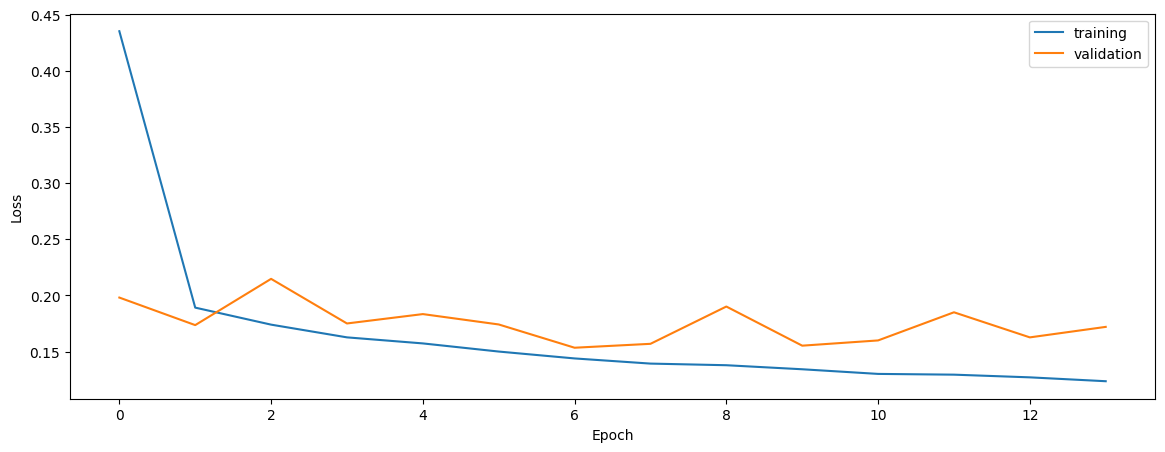

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.945290157810171


0.94082410600835


0.9318089399105384


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.9522446691603327


0.9424165263807937


0.9312300356464979


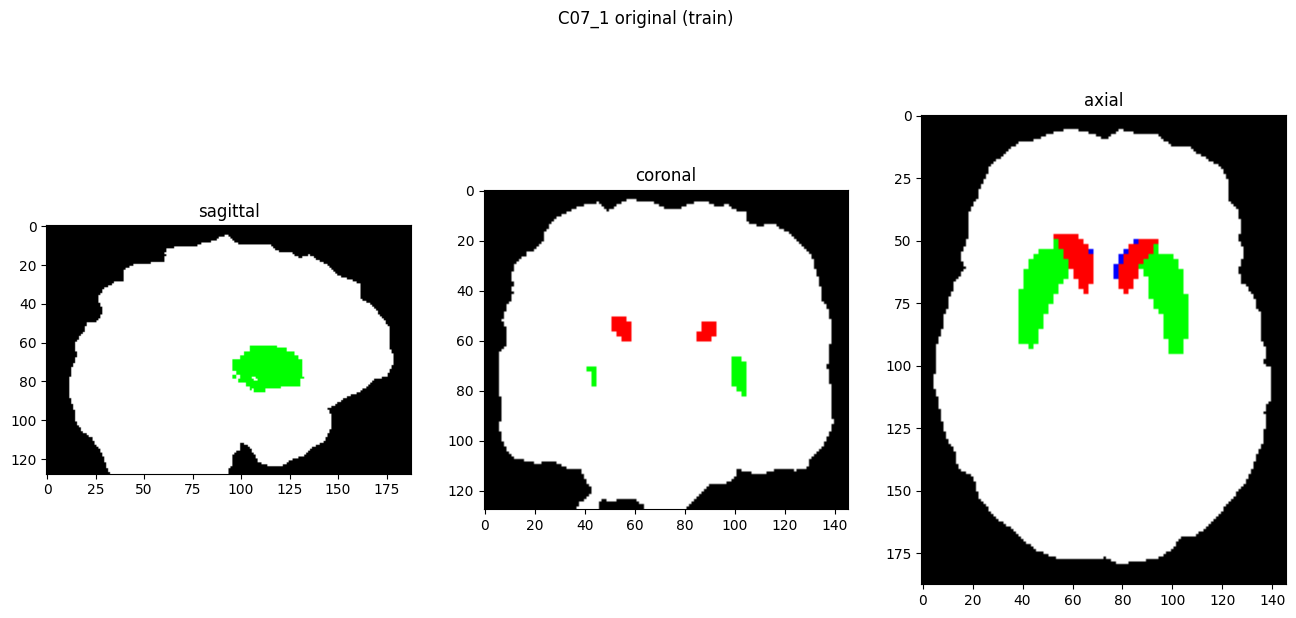

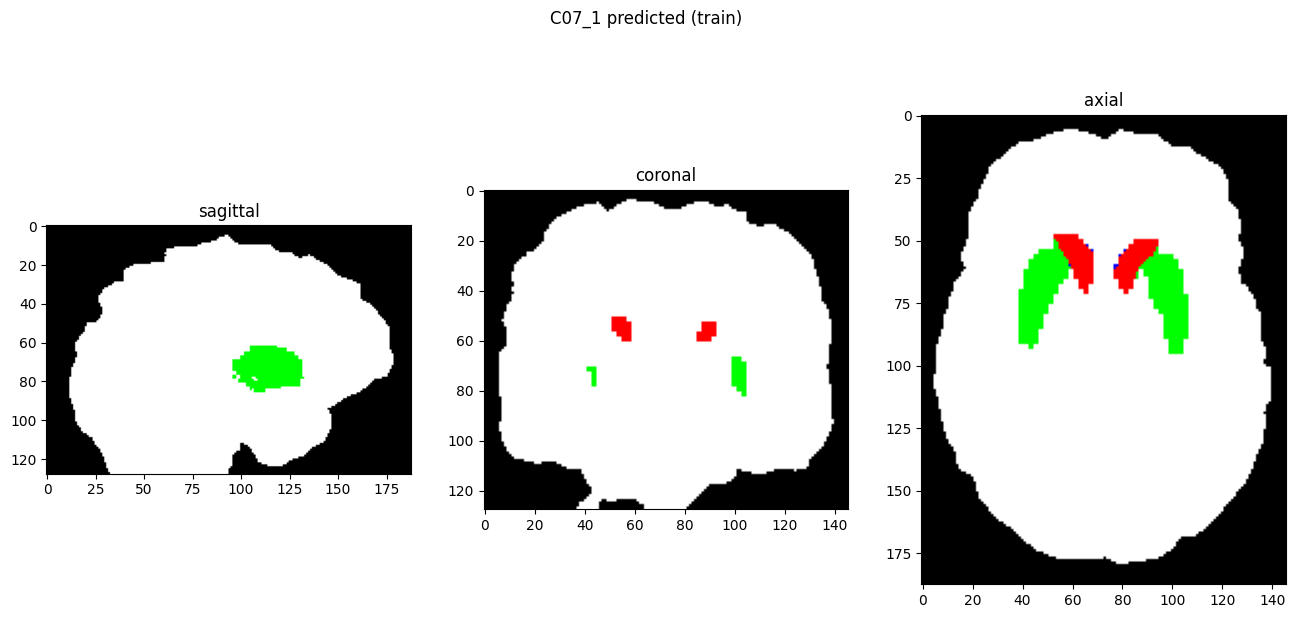

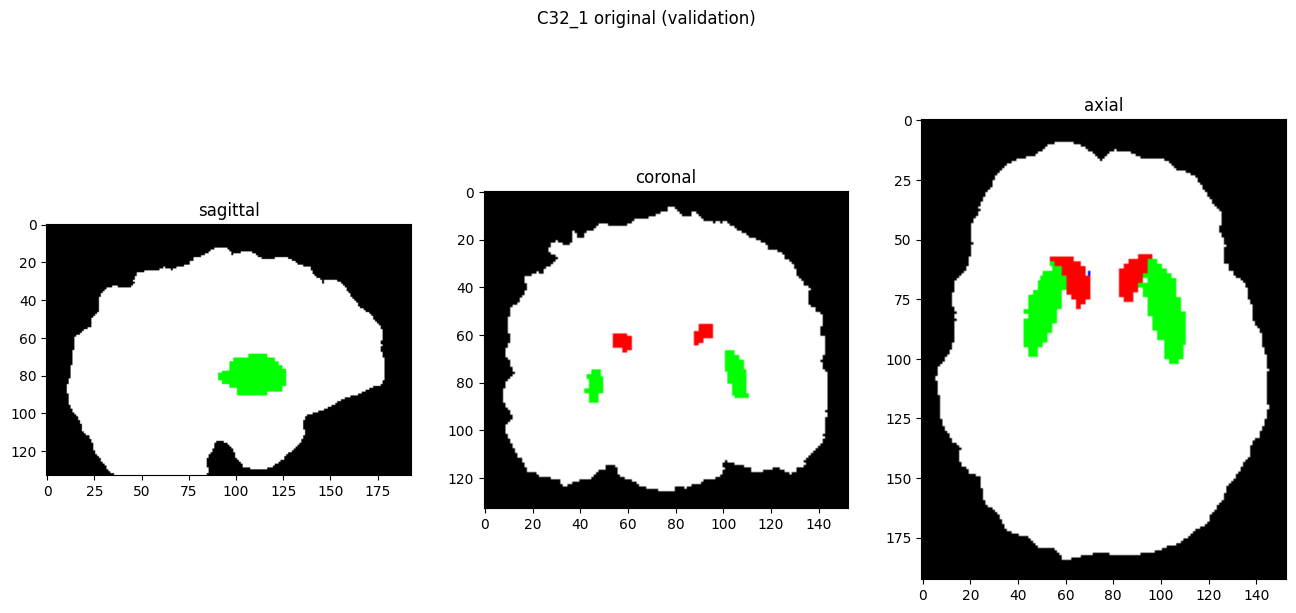

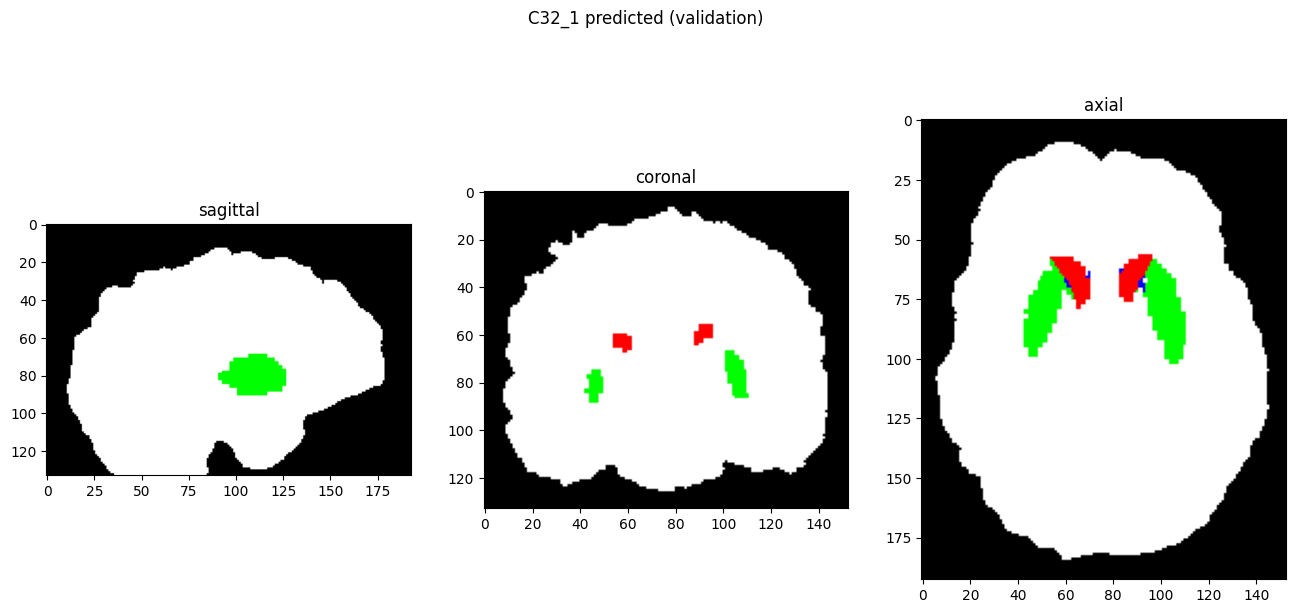

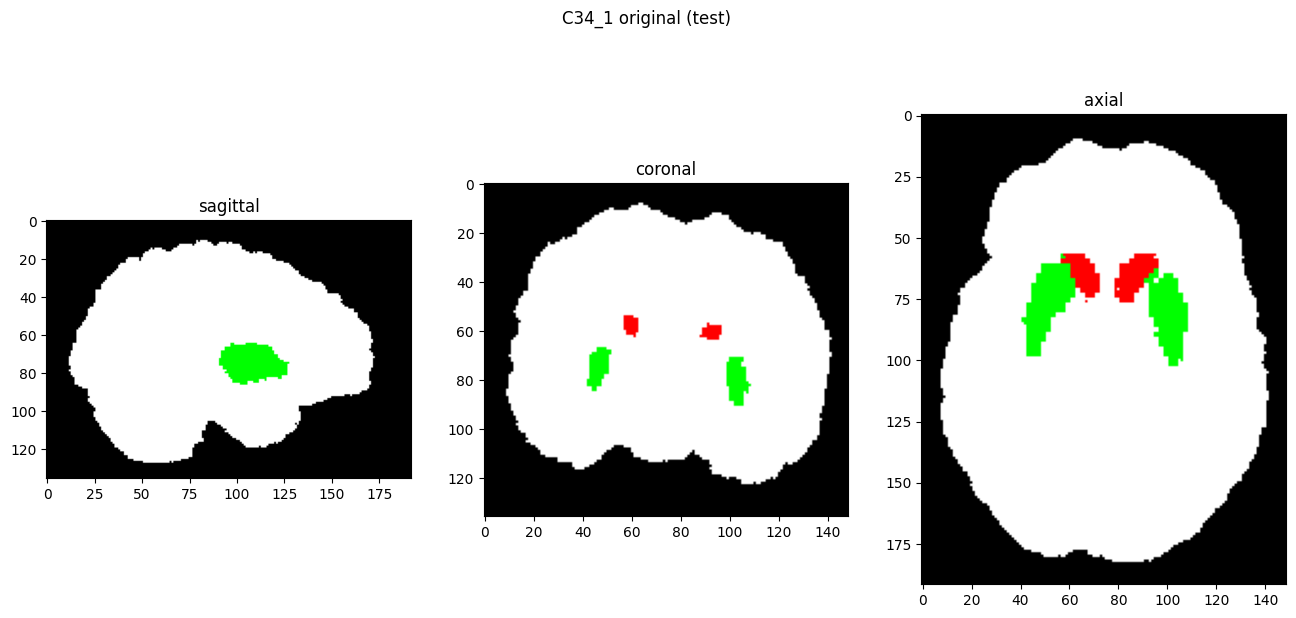

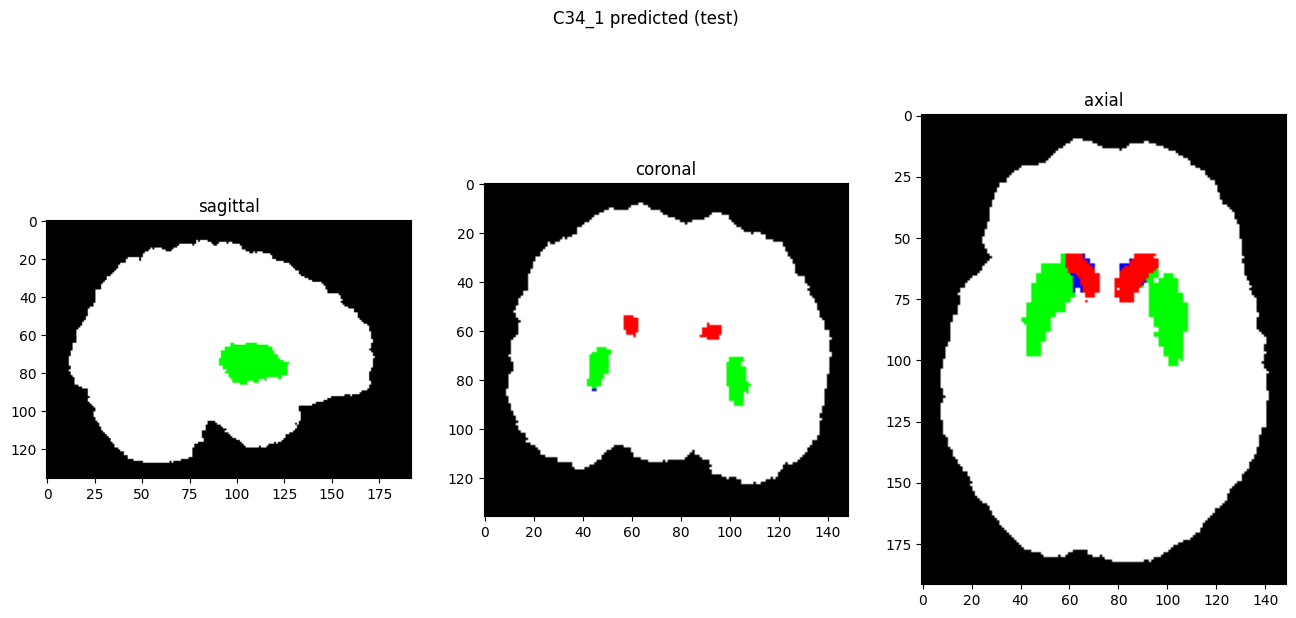

In [9]:
showResults(model, gen, threshold=0)